In [4]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math, random
from datetime import datetime
import datetime as dt
import yfinance as yf
import preprocessor as p
import re
from sklearn.linear_model import LinearRegression
from textblob import TextBlob

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.4MB 7.4MB/s 
     |████████████████████████████████| 4.4MB 26.6MB/s 
     |████████████████████████████████| 9.9MB 19.8MB/s 
     |████████████████████████████████| 12.4MB 16.5MB/s 
     |████████████████████████████████| 22.3MB 1.6MB/s 
     |████████████████████████████████| 9.5MB 17.6MB/s 
     |████████████████████████████████| 112kB 51.0MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 235kB 49.4MB/s 
     |████████████████████████████████| 7.4MB 39.9MB/s 
     |████████████████████████████████| 1.3MB 41.1MB/s 
     |████████████████████████████████| 81kB 8.1MB/s 
     |████████████████████████████████| 296kB 44.7MB/s 
     |████████████████████████████████| 143kB 43.3MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434676 sha256=a4a4b97bfbab1537de574134df64815125c297fa6bcc037d69c5372a8d055090
  Stored in direct

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#**************** FUNCTIONS TO FETCH DATA ***************************
def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year-2,end.month,end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv(''+quote+'.csv')
    if(df.empty):
        ts = TimeSeries(key='I0TWC260RP30RMO5',output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
        #Format df
        #Last 2 yrs rows => 502, in ascending order => ::-1
        data=data.head(503).iloc[::-1]
        data=data.reset_index()
        #Keep Required cols only
        df=pd.DataFrame()
        df['Date']=data['date']
        df['Open']=data['1. open']
        df['High']=data['2. high']
        df['Low']=data['3. low']
        df['Close']=data['4. close']
        df['Adj Close']=data['5. adjusted close']
        df['Volume']=data['6. volume']
        df.to_csv(''+quote+'.csv',index=False)
    return

In [3]:
#******************** ARIMA SECTION ********************
def ARIMA_ALGO(df):
    uniqueVals = df["Code"].unique()  
    len(uniqueVals)
    df=df.set_index("Code")
    #for daily basis
    def parser(x):
        return datetime.strptime(x, '%Y-%m-%d')
    def arima_model(train, test):
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(6,1 ,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat[0])
            obs = test[t]
            history.append(obs)
        return predictions
    for company in uniqueVals[:10]:
        data=(df.loc[company,:]).reset_index()
        data['Price'] = data['Close']
        Quantity_date = data[['Price','Date']]
        Quantity_date.index = Quantity_date['Date'].map(lambda x: parser(x))
        Quantity_date['Price'] = Quantity_date['Price'].map(lambda x: float(x))
        Quantity_date = Quantity_date.fillna(Quantity_date.bfill())
        Quantity_date = Quantity_date.drop(['Date'],axis =1)
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(Quantity_date)
        #plt.savefig('Trends.png')
        #plt.close(fig)
        
        quantity = Quantity_date.values
        size = int(len(quantity) * 0.80)
        train, test = quantity[0:size], quantity[size:len(quantity)]
        #fit in model
        predictions = arima_model(train, test)
        
        #plot graph
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(test,label='Actual Price')
        plt.plot(predictions,label='Predicted Price')
        plt.legend(loc=4)
        #plt.savefig('ARIMA.png')
        #plt.close(fig)
        print()
        print("##############################################################################")
        arima_pred=predictions[-2]
        print("Tomorrow's",quote," Closing Price Prediction by ARIMA:",arima_pred)
        #rmse calculation
        error_arima = math.sqrt(mean_squared_error(test, predictions))
        print("ARIMA RMSE:",error_arima)
        print("##############################################################################")
        return arima_pred, error_arima

In [5]:
#************* LSTM SECTION **********************

def LSTM_ALGO(df):
    #Split data into training set and test set
    dataset_train=df.iloc[0:int(0.8*len(df)),:]
    dataset_test=df.iloc[int(0.8*len(df)):,:]
    ############# NOTE #################
    #TO PREDICT STOCK PRICES OF NEXT N DAYS, STORE PREVIOUS N DAYS IN MEMORY WHILE TRAINING
    # HERE N=7
    ###dataset_train=pd.read_csv('Google_Stock_Price_Train.csv')
    training_set=df.iloc[:,4:5].values# 1:2, to store as numpy array else Series obj will be stored
    #select cols using above manner to select as float64 type, view in var explorer

    #Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc=MinMaxScaler(feature_range=(0,1))#Scaled values btween 0,1
    training_set_scaled=sc.fit_transform(training_set)
    #In scaling, fit_transform for training, transform for test
    
    #Creating data stucture with 7 timesteps and 1 output. 
    #7 timesteps meaning storing trends from 7 days before current day to predict 1 next output
    X_train=[]#memory with 7 days from day i
    y_train=[]#day i
    for i in range(7,len(training_set_scaled)):
        X_train.append(training_set_scaled[i-7:i,0])
        y_train.append(training_set_scaled[i,0])
    #Convert list to numpy arrays
    X_train=np.array(X_train)
    y_train=np.array(y_train)
    X_forecast=np.array(X_train[-1,1:])
    X_forecast=np.append(X_forecast,y_train[-1])
    #Reshaping: Adding 3rd dimension
    X_train=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#.shape 0=row,1=col
    X_forecast=np.reshape(X_forecast, (1,X_forecast.shape[0],1))
    #For X_train=np.reshape(no. of rows/samples, timesteps, no. of cols/features)
    
    #Building RNN
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout
    from keras.layers import LSTM
    
    #Initialise RNN
    regressor=Sequential()
    
    #Add first LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
    #units=no. of neurons in layer
    #input_shape=(timesteps,no. of cols/features)
    #return_seq=True for sending recc memory. For last layer, retrun_seq=False since end of the line
    regressor.add(Dropout(0.1))
    
    #Add 2nd LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True))
    regressor.add(Dropout(0.1))
    
    #Add 3rd LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True))
    regressor.add(Dropout(0.1))
    
    #Add 4th LSTM layer
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.1))
    
    #Add o/p layer
    regressor.add(Dense(units=1))
    
    #Compile
    regressor.compile(optimizer='adam',loss='mean_squared_error')
    
    #Training
    regressor.fit(X_train,y_train,epochs=25,batch_size=32 )
    #For lstm, batch_size=power of 2
    
    #Testing
    ###dataset_test=pd.read_csv('Google_Stock_Price_Test.csv')
    real_stock_price=dataset_test.iloc[:,4:5].values
    
    #To predict, we need stock prices of 7 days before the test set
    #So combine train and test set to get the entire data set
    dataset_total=pd.concat((dataset_train['Close'],dataset_test['Close']),axis=0) 
    testing_set=dataset_total[ len(dataset_total) -len(dataset_test) -7: ].values
    testing_set=testing_set.reshape(-1,1)
    #-1=till last row, (-1,1)=>(80,1). otherwise only (80,0)
    
    #Feature scaling
    testing_set=sc.transform(testing_set)
    
    #Create data structure
    X_test=[]
    for i in range(7,len(testing_set)):
        X_test.append(testing_set[i-7:i,0])
        #Convert list to numpy arrays
    X_test=np.array(X_test)
    
    #Reshaping: Adding 3rd dimension
    X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
    #Testing Prediction
    predicted_stock_price=regressor.predict(X_test)
    
    #Getting original prices back from scaled values
    predicted_stock_price=sc.inverse_transform(predicted_stock_price)
    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    plt.plot(real_stock_price,label='Actual Price')  
    plt.plot(predicted_stock_price,label='Predicted Price')      
    plt.legend(loc=4)
    
    #plt.savefig('static/LSTM.png')
    #plt.close(fig)
    
    
    error_lstm = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    
    
    #Forecasting Prediction
    forecasted_stock_price=regressor.predict(X_forecast)
    
    #Getting original prices back from scaled values
    forecasted_stock_price=sc.inverse_transform(forecasted_stock_price)
    
    lstm_pred=forecasted_stock_price[0,0]
    print()
    print("##############################################################################")
    print("Tomorrow's ",quote," Closing Price Prediction by LSTM: ",lstm_pred)
    print("LSTM RMSE:",error_lstm)
    print("##############################################################################")
    return lstm_pred,error_lstm

In [6]:
#***************** LINEAR REGRESSION SECTION ******************       
def LIN_REG_ALGO(df):
    #No of days to be forcasted in future
    forecast_out = int(7)
    #Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    #New df with only relevant data
    df_new=df[['Close','Close after n days']]

    #Structure data for train, test & forecast
    #lables of known data, discard last 35 rows
    y =np.array(df_new.iloc[:-forecast_out,-1])
    y=np.reshape(y, (-1,1))
    #all cols of known data except lables, discard last 35 rows
    X=np.array(df_new.iloc[:-forecast_out,0:-1])
    #Unknown, X to be forecasted
    X_to_be_forecasted=np.array(df_new.iloc[-forecast_out:,0:-1])
    
    #Traning, testing to plot graphs, check accuracy
    X_train=X[0:int(0.8*len(df)),:]
    X_test=X[int(0.8*len(df)):,:]
    y_train=y[0:int(0.8*len(df)),:]
    y_test=y[int(0.8*len(df)):,:]
    
    # Feature Scaling===Normalization
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    X_to_be_forecasted=sc.transform(X_to_be_forecasted)
    
    #Training
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    
    #Testing
    y_test_pred=clf.predict(X_test)
    y_test_pred=y_test_pred*(1.04)
    import matplotlib.pyplot as plt2
    fig = plt2.figure(figsize=(7.2,4.8),dpi=65)
    plt2.plot(y_test,label='Actual Price' )
    plt2.plot(y_test_pred,label='Predicted Price')
    
    plt2.legend(loc=4)

    #plt2.savefig('static/LR.png')
    #plt2.close(fig)
    
    error_lr = math.sqrt(mean_squared_error(y_test, y_test_pred))
    
    
    #Forecasting
    forecast_set = clf.predict(X_to_be_forecasted)
    forecast_set=forecast_set*(1.04)
    mean=forecast_set.mean()
    lr_pred=forecast_set[0,0]
    print()
    print("##############################################################################")
    print("Tomorrow's ",quote," Closing Price Prediction by Linear Regression: ",lr_pred)
    print("Linear Regression RMSE:",error_lr)
    print("##############################################################################")
    return df, lr_pred, forecast_set, mean, error_lr

In [28]:
quote = input("Enter stock ticker symbol: ")

Enter stock ticker symbol: NKE


In [29]:
get_historical(quote)
#************** PREPROCESSING ***********************
df = pd.read_csv(''+quote+'.csv')
print("##############################################################################")
print("Today's",quote,"Stock Data: ")
today_stock=df.iloc[-1:]
print(today_stock)
print("##############################################################################")
df = df.dropna()
code_list=[]
for i in range(0,len(df)):
    code_list.append(quote)
df2=pd.DataFrame(code_list,columns=['Code'])
df2 = pd.concat([df2, df], axis=1)
df=df2

[*********************100%***********************]  1 of 1 completed
##############################################################################
Today's NKE Stock Data: 
           Date        Open        High  ...       Close   Adj Close   Volume
504  2021-04-01  134.690002  134.690002  ...  132.529999  132.529999  5719900

[1 rows x 7 columns]
##############################################################################



##############################################################################
Tomorrow's NKE  Closing Price Prediction by ARIMA: 133.41752315063783
ARIMA RMSE: 2.156157182346046
##############################################################################


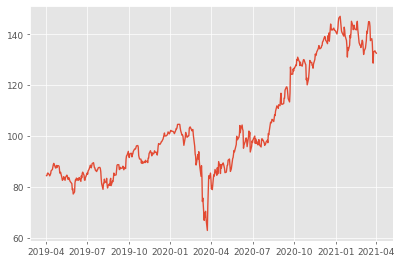

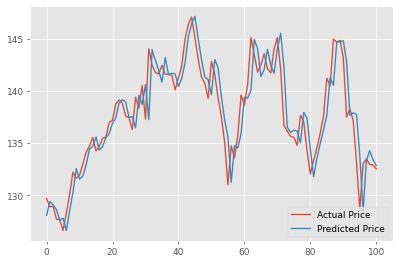

In [33]:
arima_pred, error_arima=ARIMA_ALGO(df)

Epoch 1/25
16/16 [==============================] - 7s 17ms/step - loss: 0.2314
Epoch 2/25
16/16 [==============================] - 0s 17ms/step - loss: 0.0446
Epoch 3/25
16/16 [==============================] - 0s 17ms/step - loss: 0.0180
Epoch 4/25
16/16 [==============================] - 0s 18ms/step - loss: 0.0075
Epoch 5/25
16/16 [==============================] - 0s 18ms/step - loss: 0.0060
Epoch 6/25
16/16 [==============================] - 0s 16ms/step - loss: 0.0061
Epoch 7/25
16/16 [==============================] - 0s 19ms/step - loss: 0.0040
Epoch 8/25
16/16 [==============================] - 0s 17ms/step - loss: 0.0048
Epoch 9/25
16/16 [==============================] - 0s 17ms/step - loss: 0.0041
Epoch 10/25
16/16 [==============================] - 0s 17ms/step - loss: 0.0049
Epoch 11/25
16/16 [==============================] - 0s 19ms/step - loss: 0.0047
Epoch 12/25
16/16 [==============================] - 0s 18ms/step - loss: 0.0046
Epoch 13/25
16/16 [==================

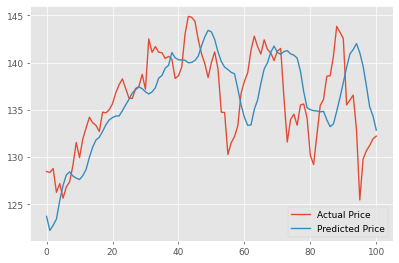

In [30]:
lstm_pred, error_lstm=LSTM_ALGO(df)


##############################################################################
Tomorrow's  NKE  Closing Price Prediction by Linear Regression:  138.36673320045523
Linear Regression RMSE: 7.5597985890122565
##############################################################################


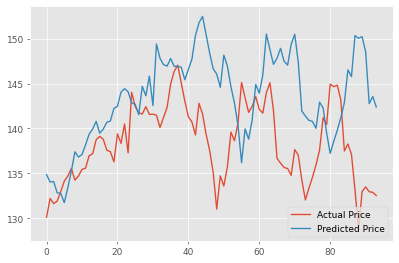

In [31]:
 df, lr_pred, forecast_set,mean,error_lr=LIN_REG_ALGO(df)

In [13]:
#Twitter API credentials
consumer_key= 'J8byEqCJVeadFYXaXXpxB0XPA'
consumer_secret= 'BtCnypxBLpOcjmH40o6sdeFkVtkEVN9ETZVj0fjLyR6kBMAduJ'

access_token='593352028-586dxldnHIrPKM2aSfsq0yJBwe9ulEQNk6LWMlln'
access_token_secret='JOnyIQx4oiR96Sp72vMQwZFJRdoOy2dtCXZqS7kbyrV2k'

num_of_tweets = int(300)

In [15]:
#Setting up modules for Tweepy
import tweepy
from textblob import TextBlob
import nltk
nltk.download('punkt')
class Tweet(object):

    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
#------------SENTIMENT ANALYSIS------------------
def retrieving_tweets_polarity(symbol):
    stock_ticker_map = pd.read_csv('Yahoo-Finance-Ticker-Symbols.csv')
    stock_full_form = stock_ticker_map[stock_ticker_map['Ticker']==symbol]
    symbol = stock_full_form['Name'].to_list()[0][0:12]

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    user = tweepy.API(auth)
    
    tweets = tweepy.Cursor(user.search, q=symbol, tweet_mode='extended', lang='en',exclude_replies=True).items(num_of_tweets)
    
    tweet_list = [] #List of tweets alongside polarity
    global_polarity = 0 #Polarity of all tweets === Sum of polarities of individual tweets
    tw_list=[] #List of tweets only => to be displayed on web page
    #Count Positive, Negative to plot pie chart
    pos=0 #Num of pos tweets
    neg=1 #Num of negative tweets
    for tweet in tweets:
        count=20 #Num of tweets to be displayed on web page
        #Convert to Textblob format for assigning polarity
        tw2 = tweet.full_text
        tw = tweet.full_text
        #Clean
        tw=p.clean(tw)
        #print("-------------------------------CLEANED TWEET-----------------------------")
        #print(tw)
        #Replace &amp; by &
        tw=re.sub('&amp;','&',tw)
        #Remove :
        tw=re.sub(':','',tw)
        #print("-------------------------------TWEET AFTER REGEX MATCHING-----------------------------")
        #print(tw)
        #Remove Emojis and Hindi Characters
        tw=tw.encode('ascii', 'ignore').decode('ascii')

        #print("-------------------------------TWEET AFTER REMOVING NON ASCII CHARS-----------------------------")
        #print(tw)
        blob = TextBlob(tw)
        polarity = 0 #Polarity of single individual tweet
        for sentence in blob.sentences:
                
            polarity += sentence.sentiment.polarity
            if polarity>0:
                pos=pos+1
            if polarity<0:
                neg=neg+1
            
            global_polarity += sentence.sentiment.polarity
        if count > 0:
            tw_list.append(tw2)
            
        tweet_list.append(Tweet(tw, polarity))
        count=count-1
    if len(tweet_list) != 0:
        global_polarity = global_polarity / len(tweet_list)
    else:
        global_polarity = global_polarity
    neutral=num_of_tweets-pos-neg
    if neutral<0:
      neg=neg+neutral
      neutral=20
    print()
    print("##############################################################################")
    print("Positive Tweets :",pos,"Negative Tweets :",neg,"Neutral Tweets :",neutral)
    print("##############################################################################")
    labels=['Positive','Negative','Neutral']
    sizes = [pos,neg,neutral]
    explode = (0, 0, 0)
    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    fig1, ax1 = plt.subplots(figsize=(7.2,4.8),dpi=65)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    #plt.savefig('static/SA.png')
    #plt.close(fig)
    plt.show()
    if global_polarity>0:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Positive")
        print("##############################################################################")
        tw_pol="Overall Positive"
    else:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Negative")
        print("##############################################################################")
        tw_pol="Overall Negative"
    
    
    return global_polarity,tw_list,tw_pol,pos,neg,neutral

In [17]:
#---------RECOMENDATIONS BASED ON TWEETS & Models-------------------
def recommending(df, global_polarity,today_stock,mean):
    if today_stock.iloc[-1]['Close'] < mean:
        if global_polarity > 0:
            idea="RISE"
            decision="BUY"
            print()
            print("##############################################################################")
            print("According to the ML Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected => ",decision)
        elif global_polarity <= 0:
            idea="FALL"
            decision="SELL"
            print()
            print("##############################################################################")
            print("According to the ML Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected => ",decision)
    else:
        idea="FALL"
        decision="SELL"
        print()
        print("##############################################################################")
        print("According to the ML Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected => ",decision)
    return idea, decision


##############################################################################
Positive Tweets : 164 Negative Tweets : 11 Neutral Tweets : 125
##############################################################################


<Figure size 468x312 with 0 Axes>

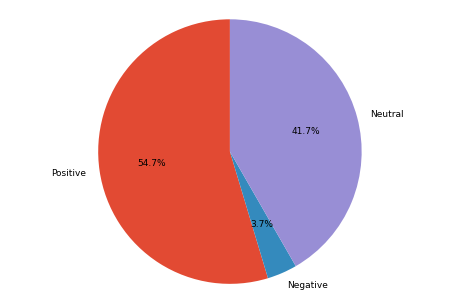


##############################################################################
Tweets Polarity: Overall Positive
##############################################################################


In [32]:
#Showing sentiment analysis
polarity,tw_list,tw_pol,pos,neg,neutral = retrieving_tweets_polarity(quote)

In [19]:
idea, decision=recommending(df, polarity,today_stock,mean)
print()
print("Forecasted Prices for Next 7 days:")
print(forecast_set)


##############################################################################
According to the ML Predictions and Sentiment Analysis of Tweets, a RISE in BA stock is expected =>  BUY

Forecasted Prices for Next 7 days:
[[246.35002374]
 [254.30942116]
 [251.98667054]
 [257.64336055]
 [259.13511263]
 [261.84832379]
 [260.08624818]]
